In [2]:
import torch
torch.__version__

'2.4.0+cu121'

In [3]:
torch.cuda.is_available()

True

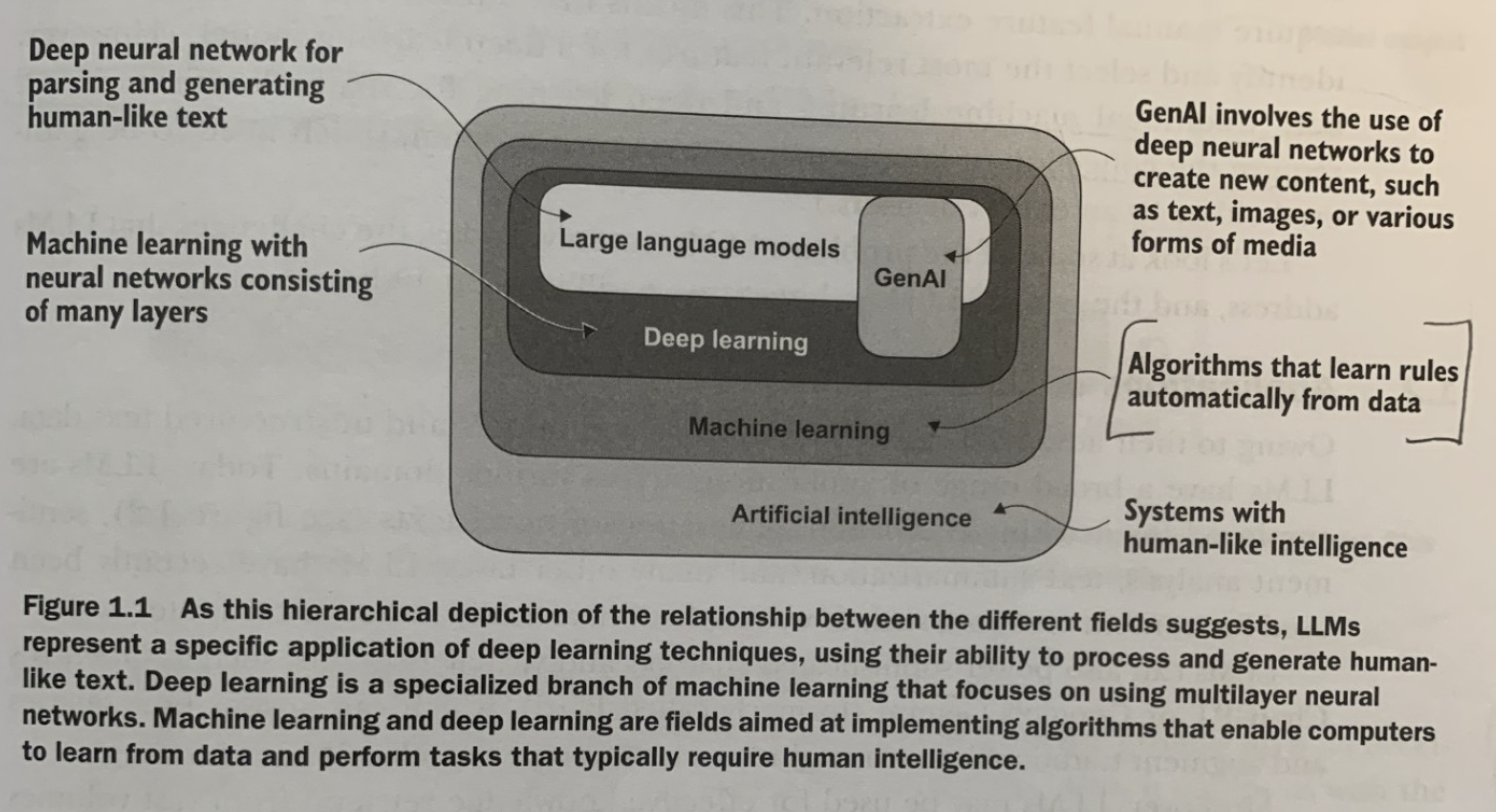

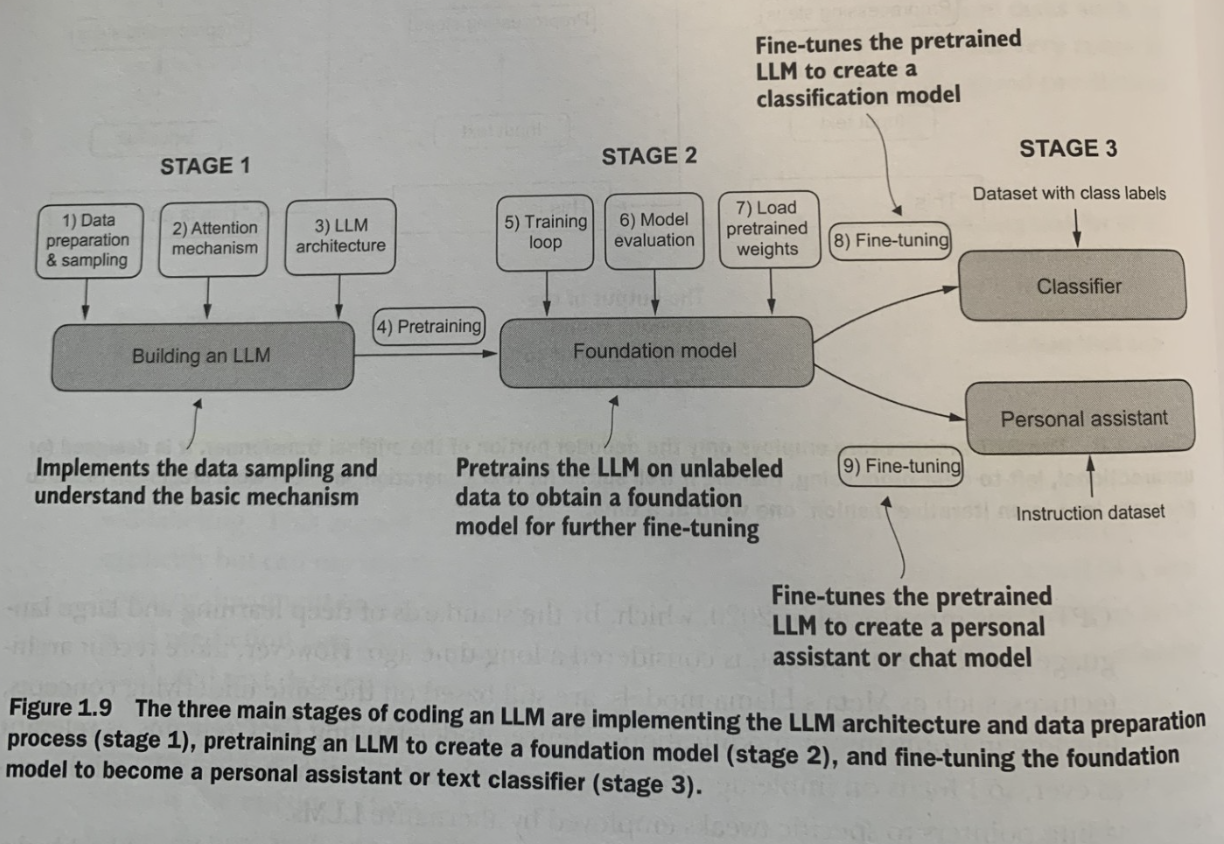

# BEGIN TOKENIZATION

## Download "The Verdict" --- Tokenization

In [9]:
import os
import urllib.request
if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

In [10]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


### How can we best split this text to obtain a list of tokens?  In this example we use Python's regular expression library. 

In [11]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


### We don't only want to split on whitespaces but also commas and periods, so let's modify the regular expression to do that as well

In [12]:
result = re.split(r'([,.]|\s)', text)

print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


### As we can see, this creates empty strings, let's remove them

In [13]:
# Strip whitespace from each item and then filter out any empty strings.
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


### This looks pretty good, but let's also handle other types of punctuation, such as periods, question marks, and so on

In [14]:
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


### Apply tokenization to the raw text of "The Verdict"

In [15]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


### Let's calculate the total number of tokens

In [16]:
print(len(preprocessed))

4690


### Quick visual check

In [17]:
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


### From these tokens, we can now build a vocabulary that consists of all the unique tokens

In [18]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

1130


### In this next code section, we are essentially building a dictionary.  "Enumerate" puts a counter on the iterable:

In [19]:
vocab = {token:integer for integer,token in enumerate(all_words)}

In [22]:
for i, item in enumerate(vocab.items()):
    if 45 >= i >= 10:
        print(item)
    if i >= 50:
        break

('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)


### Implement a Tokenizer Class

In [23]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
                                
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

### Take a sample text and print the associated token ids.  

In [24]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


### Turn the token IDs back into text.

In [25]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

### But what happens when we expose the tokenizer to words not contained in the original training set?

In [26]:
text = "Sup my dog."
print(tokenizer.encode(text))

KeyError: 'Sup'

### Lesson!!!! You must consider large and diverse training sets to extend the vocabulary when working on LLMs.  

### Now we can add special context tokens

### Let's modify the vocabulary to include the two special tokens <|unk|> and <|endoftext|>

In [27]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [28]:
len(vocab.items())

1132

### Let's check the last five in vocab to make sure the tokens are still there.

In [29]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


### Now let's rebuild the tokenizer 

In [30]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int 
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

### And let's give the new tokenizer a whirl

In [34]:
text1 = "Sup, do you like tea?"
text2 = "In the sunlit terraces of the palace skippity boppity bidlelitty badoopity."
text = " <|endoftext|> ".join((text1,text2))
print(text)

Sup, do you like tea? <|endoftext|> In the sunlit terraces of the palace skippity boppity bidlelitty badoopity.


In [35]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 1131, 1131, 1131, 1131, 7]


### Lots of unknowns because you threw in a lot of dumb words.    

### Let's detokenize to see what it looks like in the opposite direction.

In [36]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|> <|unk|> <|unk|> <|unk|> <|unk|>.'

# Byte Pair Encoding

#### GPT-2 used BytePair encoding (BPE) as its tokenizer it allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words. 
#### For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges

In [37]:
pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [tiktoken]
Note: you may need to restart the kernel to use updated packages.


In [38]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.9.0


### Of note, the version in the textbook is 0.7.0

In [39]:
tokenizer = tiktoken.get_encoding("gpt2")

In [40]:
text = (
    "Sup, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[40784, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [41]:
strings = tokenizer.decode(integers)

print(strings)

Sup, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


### The gpt2 version of the tokenizer can break down words into subwords and individual characters. (Exercise 2.1)

In [57]:
text = (
    "subcannonicalanti-inflamatory"
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[7266, 66, 8825, 605, 17096, 12, 10745, 2543, 2870]


In [58]:
strings = tokenizer.decode(integers)

print(strings)

subcannonicalanti-inflamatory


# Data sampling in a sliding window

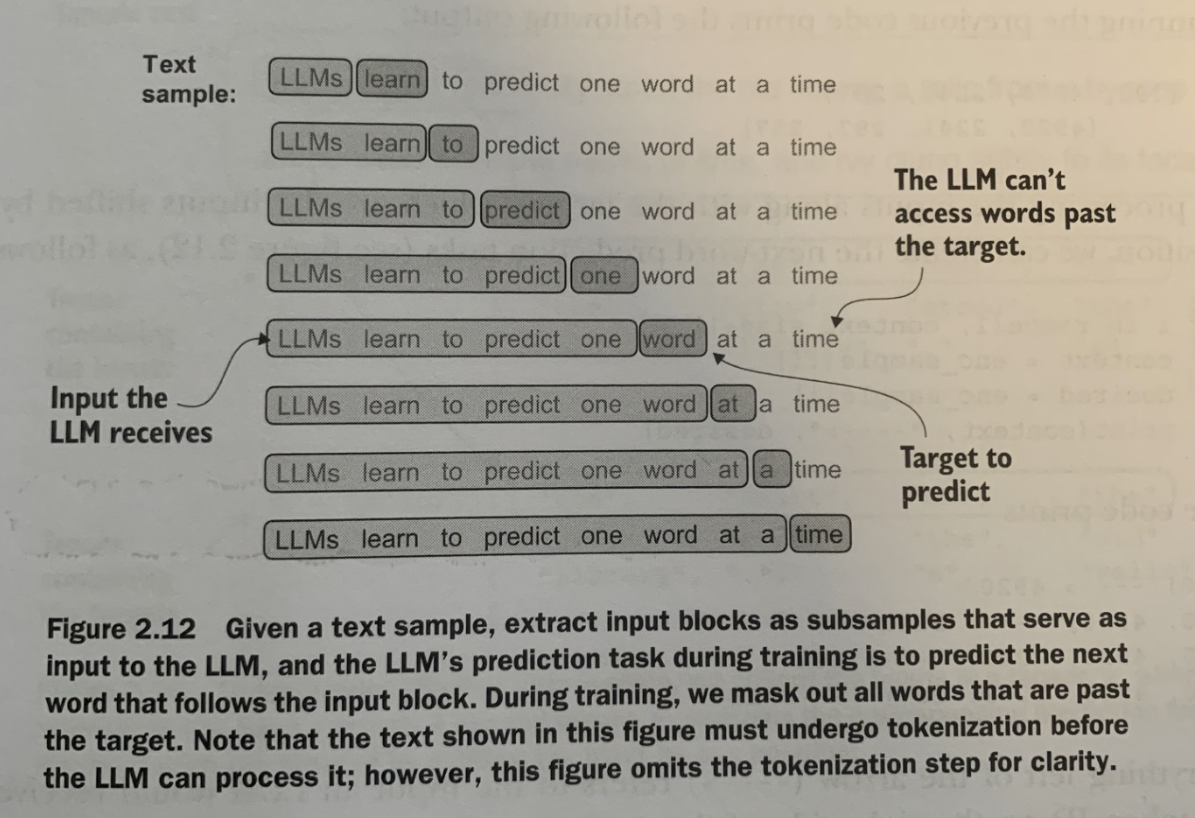

In [59]:

with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


In [60]:
# For illustrative purposes, we're going to remove the first 50 words because it makes for a more interesting text passage in the next steps.
enc_sample = enc_text[50:]

In [61]:
context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [62]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [63]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


In [64]:
# Listing 2.5

import torch
print("PyTorch version:", torch.__version__)

from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

PyTorch version: 2.4.0+cu121


In [65]:
# Listing 2.6

def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

### batch_size = 4 Controls how many examples (i.e., sequences) are grouped and passed to the model at once during training or inference. 
### max_length = 256 Sets the maximum number of tokens per sequence. 
### stride = 128 Controls the overlap between consecutive chunks. 
### shuffle = True Tells the DataLoader to randomly shuffle the order of batches each epoch. 
### drop_last = True If True, the last incomplete batch is dropped (if its size < batch_size) 
### num_workers = 0 Sets the number of parallel processes to use for loading data.      

### Let's test the dataloader with a batch size of 1 for an LLM with a context size of 4.

In [66]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [67]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


### "Batch sizes of 1, such as we have sampled from the data loader so far, are useful for illustrative purposes.  If you have previous experience with deep learning, you may know that small batch sizes require less memory during training but lead to more noisy model updates.  Just like in regular deep learning, the batch size is a tradeoff and a hyperparameter to experiment with when training LLMs..." 

### Let's look briefly at how we can use the data loader to sample with a batch size greater than 1:

In [68]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


### Let's see how the token ID to embdedding vector conversion works with a hands-on example.  Suppose we have the following four input toekns with IDs 2, 3, 5 , and 1 (after tokenization):

In [69]:
input_ids = torch.tensor([2, 3, 5, 1])

### For the sake of simplicity, suppose we have a small vocabulary of only 6 words (instead of the 50,257 words in the BPE tokenizer vocab), and we want to create embeddings of size 3 (in GPT-3, the embidding size is 12,288 dimensions)

In [71]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


In [72]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


### Because the embedding layer is just a more efficient implementation that is equivalent to the one-hot encoding and matrix-multiplication approach it can be seen as a neural network layer that can be optimized via backpropagation

The weight matrix of the embedding layer contains small, random values.  These values are optimized during LLM training as part of the LLM optimization itself.  Moreover, we can see that the weight matrix has six rows and tree columns.  There is one row for each of the six possible tokens in the vocabulary, and there is one column for each of the three embedding dimensions. Now let's apply it to a token ID to obtain the embedding vector:

In [73]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


#### We've seen how to convert a single token ID into a three-dimensional embedding vector.  Let's now apply that to all four input ID's. Each row in this output matrix is obtained via a lookup operation from the embedding weight matrix.   

In [75]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


# POSITION-AWARE EMBEDDINGS: Relative Positional Embeddings and Absolute Positional Embeddings

#### Absolute - For each position in the input sequence, a unique embedding is added to the token's embedding to convey it's exact location.  For instance, the first token will have a specific positional embedding, the second token another distinct embedding, and so on. 

#### Positional - emphasis is on relative position or distance between tokens.  "How far apart" vs "at which exact position."

#### Open AI's GPT models use absolute positional embeddings. 

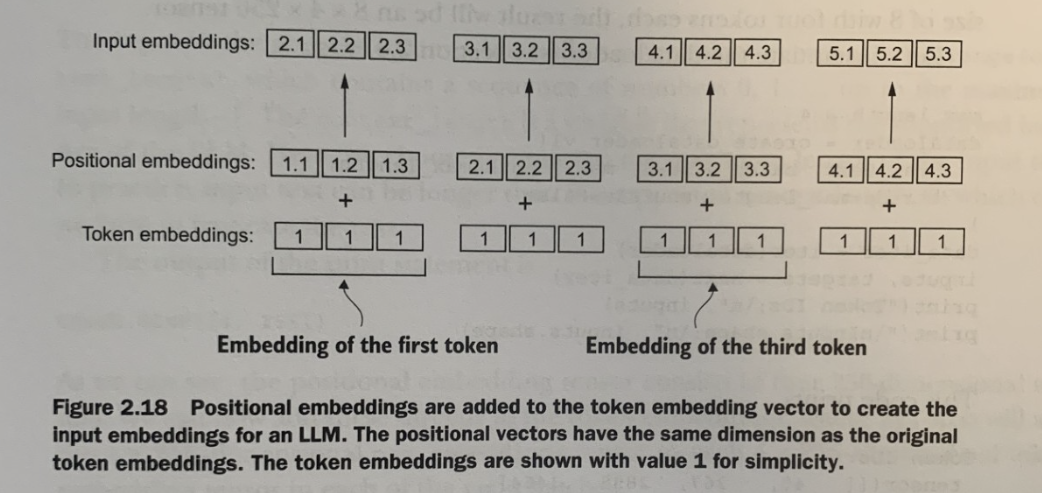

In [76]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

### If we sample data from the dataloader, we embed the tokens in each batch into a 256-dimensional vector
### If we have a batch size of 8 with 4 tokens each, this results in a 8 x 4 x 256 tensor:

In [77]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [78]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


### Let's now use the embedding layer to embded these token IDs into 256-dimensional vectors:

In [79]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
print(token_embeddings)

torch.Size([8, 4, 256])
tensor([[[ 0.4913,  1.1239,  1.4588,  ..., -0.3995, -1.8735, -0.1445],
         [ 0.4481,  0.2536, -0.2655,  ...,  0.4997, -1.1991, -1.1844],
         [-0.2507, -0.0546,  0.6687,  ...,  0.9618,  2.3737, -0.0528],
         [ 0.9457,  0.8657,  1.6191,  ..., -0.4544, -0.7460,  0.3483]],

        [[ 1.5460,  1.7368, -0.7848,  ..., -0.1004,  0.8584, -0.3421],
         [-1.8622, -0.1914, -0.3812,  ...,  1.1220, -0.3496,  0.6091],
         [ 1.9847, -0.6483, -0.1415,  ..., -0.3841, -0.9355,  1.4478],
         [ 0.9647,  1.2974, -1.6207,  ...,  1.1463,  1.5797,  0.3969]],

        [[-0.7713,  0.6572,  0.1663,  ..., -0.8044,  0.0542,  0.7426],
         [ 0.8046,  0.5047,  1.2922,  ...,  1.4648,  0.4097,  0.3205],
         [ 0.0795, -1.7636,  0.5750,  ...,  2.1823,  1.8231, -0.3635],
         [ 0.4267, -0.0647,  0.5686,  ..., -0.5209,  1.3065,  0.8473]],

        ...,

        [[-1.6156,  0.9610, -2.6437,  ..., -0.9645,  1.0888,  1.6383],
         [-0.3985, -0.9235, -1.31

## For a GPT model's absolute embedding approach, we just need to crate another embedding layer that has the same embedding dimension as the token_embedding layer:

In [80]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


#### To create the input embeddings used in an LLM, we simply add the token and the positional embeddings:

In [81]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


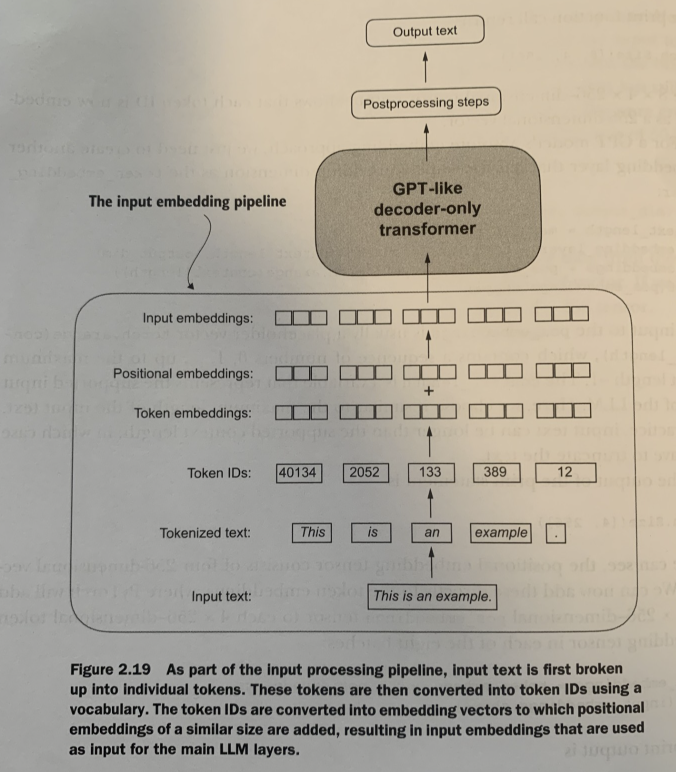